In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
path = '/home/dario/phd/retrieval_base/'
    
from retrieval_base.retrieval import pre_processing, Retrieval
from retrieval_base.config import Config
import config_freechem as conf

%load_ext autoreload
%autoreload 2

config_file = 'config_freechem.txt'
target = 'TWA28'
run = 'rev_4' # important to set this to the correct run 

conf = Config(path=path, target=target, run=run)
conf(config_file)

ret = Retrieval(
    conf=conf, 
    evaluation=True,
    )

ret.CB.plot_summary=False
ret.PMN_callback_func(
            n_samples=None, 
            n_live=None, 
            n_params=None, 
            live_points=None, 
            posterior=None, 
            stats=None,
            max_ln_L=None, 
            ln_Z=None, 
            ln_Z_err=None, 
            nullcontext=None
            )

  analysing data from ./retrieval_outputs/rev_4/test_.txt
 Copying integrated emission contribution to ModelSpectrum
 Saved m_spec_species.pkl to ./retrieval_outputs/rev_4/test_data/
Copying integrated contribution emission from m_spec[K2166] to PT


Elapsed time per evaluation: 2.04 seconds

--- K2166 -------------------------
Reduced chi-squared (w/o uncertainty-model) = 34.61
(chi-squared=966573.88, n_dof=27925)

--- Total -------------------------
Reduced chi-squared (w/o uncertainty-model) = 34.61
(chi-squared=966573.88, n_dof=27925)

Best-fitting free parameters:
log_a = 0.01
log_l = -1.45
alpha = 0.00
beta = 1.62
log_g = 3.56
epsilon_limb = 0.17
vsini = 11.63
rv = 12.64
log_12CO = -3.50
log_13CO = -5.55
log_H2O = -3.79
log_H2O_181 = -5.88
log_HF = -7.75
log_Na = -5.60
log_Ca = -5.04
log_Ti = -7.26
dlnT_dlnP_0 = 0.05
dlnT_dlnP_1 = 0.28
dlnT_dlnP_2 = 0.08
dlnT_dlnP_3 = 0.04
dlnT_dlnP_4 = 0.21
dlnT_dlnP_5 = 0.02
dlnT_dlnP_6 = -0.02
dlnT_dlnP_7 = 0.28
T_0 = 5602.44

--- K2166 ------

In [2]:
params = ret.Param.params.copy()
params['vsini'] = 0.0

In [3]:
params['vsini']

0.0

In [4]:
mass_fractions = ret.Chem(ret.Param.VMR_species, ret.Param.params)
temperature = ret.PT(ret.Param.params)

In [5]:
ret.pRT_atm['K2166'].wave_range_micron

array([[1.98966732, 2.03160402],
       [2.06339693, 2.10683769],
       [2.14277922, 2.18782962],
       [2.22848093, 2.27526815],
       [2.3212855 , 2.36994699],
       [2.4221081 , 2.47280001]])

In [6]:
ret.pRT_atm['K2166'].atm

In [19]:
import petitRADTRANS.nat_cst as nc
from retrieval_base.spectrum import ModelSpectrum

i = 4
atm_i = ret.pRT_atm['K2166'].atm[i]
atm_i.calc_flux(
                temperature, 
                mass_fractions, 
                gravity=10.0**params['log_g'], 
                mmw=mass_fractions['MMW'], 
                Kzz=ret.pRT_atm['K2166'].K_zz, 
                fsed=ret.pRT_atm['K2166'].f_sed, 
                sigma_lnorm=ret.pRT_atm['K2166'].sigma_g,
                give_absorption_opacity=ret.pRT_atm['K2166'].give_absorption_opacity, 
                contribution=False, 
                )
wave_i = nc.c / atm_i.freq
# flux_i = np.nan_to_num(atm_i.flux, nan=0.0)
flux_i = np.where(np.isfinite(atm_i.flux), atm_i.flux, 0.0)
overflow = np.log(atm_i.flux) > 20
atm_i.flux[overflow] = 0.0

flux_i = atm_i.flux *  nc.c / (wave_i**2)

# Convert [erg cm^{-2} s^{-1} cm^{-1}] -> [erg cm^{-2} s^{-1} nm^{-1}]
# flux_i /= 1e7
flux_i = flux_i * 1e-7

# Convert [cm] -> [nm]
wave_i *= 1e7

# normalize flux
flux_i /= np.median(flux_i)






In [25]:
# direct integration


def rot_int_cmj(w, s, vsini, eps=0.6, nr=10, ntheta=100, dif = 0.0):
    '''
    A routine to quickly rotationally broaden a spectrum in linear time.

    INPUTS:
    s - input spectrum

    w - wavelength scale of the input spectrum
    
    vsini (km/s) - projected rotational velocity
    
    OUTPUT:
    ns - a rotationally broadened spectrum on the wavelength scale w

    OPTIONAL INPUTS:
    eps (default = 0.6) - the coefficient of the limb darkening law
    
    nr (default = 10) - the number of radial bins on the projected disk
    
    ntheta (default = 100) - the number of azimuthal bins in the largest radial annulus
                            note: the number of bins at each r is int(r*ntheta) where r < 1
    
    dif (default = 0) - the differential rotation coefficient, applied according to the law
    Omeg(th)/Omeg(eq) = (1 - dif/2 - (dif/2) cos(2 th)). Dif = .675 nicely reproduces the law 
    proposed by Smith, 1994, A&A, Vol. 287, p. 523-534, to unify WTTS and CTTS. Dif = .23 is 
    similar to observed solar differential rotation. Note: the th in the above expression is 
    the stellar co-latitude, not the same as the integration variable used below. This is a 
    disk integration routine.

    '''

    ns = np.copy(s)*0.0
    tarea = 0.0
    dr = 1./nr
    for j in range(0, nr):
        r = dr/2.0 + j*dr
        area = ((r + dr/2.0)**2 - (r - dr/2.0)**2)/int(ntheta*r) * (1.0 - eps + eps*np.cos(np.arcsin(r)))
        for k in range(0,int(ntheta*r)):
            th = np.pi/int(ntheta*r) + k * 2.0*np.pi/int(ntheta*r)
            if dif != 0:
                vl = vsini * r * np.sin(th) * (1.0 - dif/2.0 - dif/2.0*np.cos(2.0*np.arccos(r*np.cos(th))))
                ns += area * np.interp(w + w*vl/2.9979e5, w, s)
                tarea += area
            else:
                vl = r * vsini * np.sin(th)
                ns += area * np.interp(w + w*vl/2.9979e5, w, s)
                tarea += area
          
    return ns/tarea


# Create a ModelSpectrum instance
m_spec_fast = ModelSpectrum(
        wave=wave_i, flux=flux_i, 
        lbl_opacity_sampling=atm_i.lbl_opacity_sampling
        )

# Apply radial-velocity shift, rotational/instrumental broadening
vsini = 5.0
m_spec_fast.shift_broaden_rebin(
    rv=0.0, 
    vsini=vsini, 
    epsilon_limb=params['epsilon_limb'], 
    out_res=1e6, 
    in_res=m_spec_fast.resolution, 
    rebin=False, 
    )
print(f' Wave range {np.max(m_spec_fast.wave) - m_spec_fast.wave.min():.2f} nm')
m_spec_fast.rebin(d_wave=ret.pRT_atm['K2166'].d_wave[i,:], replace_wave_flux=True)

m_spec_int = ModelSpectrum(
        wave=wave_i, flux=flux_i, 
        lbl_opacity_sampling=atm_i.lbl_opacity_sampling
        )

m_spec_int.flux = rot_int_cmj(m_spec_int.wave, m_spec_int.flux, vsini=vsini, eps=params['epsilon_limb'], nr=20, ntheta=100)
m_spec_int.flux = np.interp(ret.pRT_atm['K2166'].d_wave[i,:], m_spec_int.wave, m_spec_int.flux)
m_spec_int.wave = ret.pRT_atm['K2166'].d_wave[i,:]

 Wave range 48.67 nm


/home/dario/phd/retrieval_base/retrieval_base/spectrum.py:286: RuntimeWarning: invalid value encountered in sqrt
  sigma_LSF = np.sqrt(1/out_res**2 - 1/in_res**2) / \


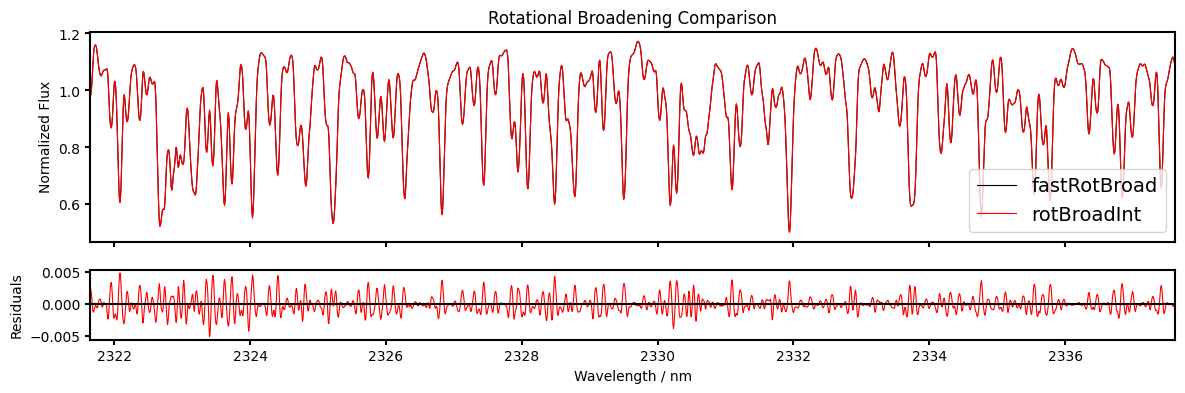

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(14,4), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
lw = 0.8
det = 0
ax[0].plot(m_spec_fast.wave[det], m_spec_fast.flux[det], label='fastRotBroad', c='k',lw=lw)
ax[0].plot(m_spec_int.wave[det], m_spec_int.flux[det], label='rotBroadInt', c='r',lw=lw)

res = m_spec_fast.flux[det] - m_spec_int.flux[det]
ax[1].plot(m_spec_fast.wave[det], res, color='r',lw=lw)
ax[1].axhline(0.0, color='k', linestyle='-')

ax[0].legend(fontsize=14)
ax[0].set(ylabel='Normalized Flux', title='Rotational Broadening Comparison', xlim=(np.min(m_spec_fast.wave[det]), np.max(m_spec_fast.wave[det])))
ax[1].set(xlabel='Wavelength / nm', ylabel='Residuals')
plt.show()

fig.savefig('rot_broad_comparison.png', dpi=200, bbox_inches='tight')

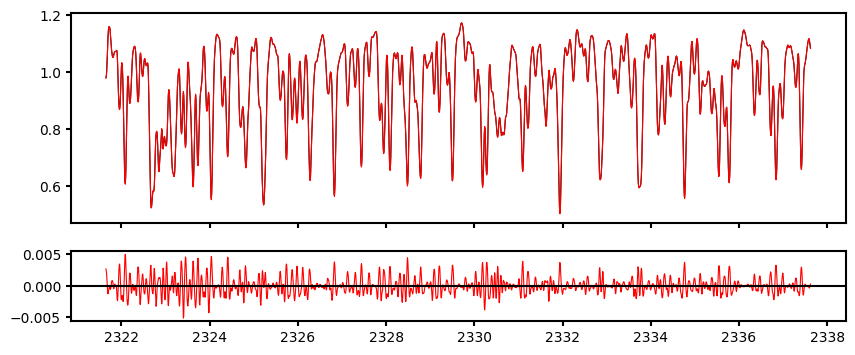

In [27]:
# apply instrumental broadening

out_res = 120e3
in_res = m_spec_fast.resolution
m_spec_fast.flux[det] = m_spec_fast.instr_broadening(m_spec_fast.wave[det], m_spec_fast.flux[det], out_res=out_res, in_res=in_res)
m_spec_int.flux[det] = m_spec_int.instr_broadening(m_spec_int.wave[det], m_spec_int.flux[det], out_res=out_res, in_res=in_res)

fig, ax = plt.subplots(2, 1, figsize=(10,4), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
lw = 0.8
det = 0
ax[0].plot(m_spec_fast.wave[det], m_spec_fast.flux[det], label='fastRotBroad', c='k',lw=lw)
ax[0].plot(m_spec_int.wave[det], m_spec_int.flux[det], label='rotBroadInt', c='r',lw=lw)

res = m_spec_fast.flux[det] - m_spec_int.flux[det]
ax[1].plot(m_spec_fast.wave[det], res, color='r',lw=lw)
ax[1].axhline(0.0, color='k', linestyle='-')

plt.show()

fig.savefig('rot_broad_comparison_with_instrbroad.png', dpi=200, bbox_inches='tight')